# GANs(Generative Adversarial Networks, 적대적 생성신경망)
- GANs란?
- 구현
- tutorials by tensorflow :  https://www.tensorflow.org/beta/tutorials/generative/dcgan

### GANs란?
- GAN은 두 개의 신경망, 즉 생성자(Generator)와 판별자(Discriminator)로 구성된다. 이 두 신경망은 서로 경쟁하면서 훈련되어 서로의 능력치를 상승시켜준다
  - 생성자(Generator): 생성자의 목표는 실제와 같은 데이터를 생성하는 것이다.
  - 판별자(Discriminator): 판별자는 생성자가 생성한 이미지와 실제 이미지를 구별하는 것을 학습한다. 즉, 판별자는 생성된 이미지와 실제 이미지를 구별하여 실제 이미지에 대해 1을 출력하고 생성된 이미지에 대해 0을 출력하도록 훈련된.

#### GANs의 학습 과정
- 판별자 학습: 일반적인 분류기를 학습하는 것과 같다. Generator에서 생성된 Fake데이터와 사전에 수집한 Real 데이터를 각각 판별자에 보낸다. 그 후 예측된 값과 실제 레이블의 오차를 계산하고 역전파 알고리즘을 통해 가중치를 업데이트한다.
  - 결국 Fake와 Real을 잘 판단 할 수 있도록 학습된다.
- 생성자 학습: 생성자는 인풋으로 난수로 생성된 데이터를 받는다. 생성자의 목적은 판별기를 속여 Real데이터라고 속이는것이기 때문에 판별자의 결과를 피드백을 받아 생성자의 가중치들을 학습시킨다.


### Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.15.0'

### Loading and pre-processing the dataset
- mnist 데이터를 사용하여 GANs를 구현해본다

In [2]:
# 이미지 분류를 할것이 아니라 그냥 학습데이터만 있어도 충분하다(검 데이터 X)
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# shape에 channel에 대한 정보가 없다
x_train.shape

(60000, 28, 28)

In [4]:
y_train.shape

(60000,)

0


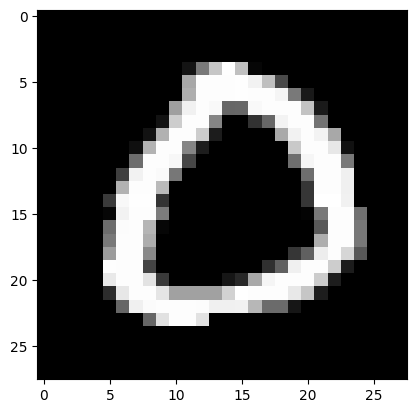

In [5]:
# 데이터 셋에서 임의의 데이터 출력
i=np.random.randint(0,60000)
print(y_train[i])
plt.imshow(x_train[i], cmap='gray');

In [6]:
# 합성곱 신경망에 입력하기 위해 채널을 추가해준다.
# astype으로 정수를 실수로 변환해준다.
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')

In [7]:
x_train.shape

(60000, 28, 28, 1)

In [8]:
x_train[0].min(), x_train[0].max()

(0.0, 255.0)

In [9]:
# 데이터 정규화 -> 0~1이 아닌 -1~1로 정규화한다 -> GANs 개발자가 추천하는 범위(성능 때문)
# x_train = x_train / 255은 0~1 로 정규화되지만 아래 식은 -1~1로 정규화된다.
x_train = (x_train - 127.5)/ 127.5

In [10]:
x_train[0].min(), x_train[0].max()

(-1.0, 1.0)

In [11]:
buffer_size = 60000
batch_size = 256

In [12]:
buffer_size / batch_size

234.375

In [13]:
type(x_train)

numpy.ndarray

In [14]:
# x_train 데이터들을 미니배치 방식으로 데이터셋을 구성한다. -> 복잡한 신경망일 수 록 미니배치가 좋다.
# from_tensor_slices는 넘파이, 리스트 등 다양한 형식을 데이터 셋타입으로 변환
# shuffle은 buffer_size(데이터 개수)만큼 데이터셋의 요소들을 섞는다
# batch는 데이터셋을 batch_size만큼 나누어 관리한다.(234개의 데이터셋)
x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

In [15]:
type(x_train) # BatchDataset 타입으로 신경망에 한번에 학습 시킬 이미지를 모아둔 type이다. (tensorflow 변수)

tensorflow.python.data.ops.batch_op._BatchDataset

In [16]:
# shape의 None은 배치당 가지고있는 이미지의 개수이다.(배치마다 다를 수 있어서 None으로 표기 -> 가변적인 데이터 포인트 개)
x_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

### Building the generator
- 생성자 구성
  - 임의로 생성된 수를 받아 신경망에 통과시킨후 끝에 출력되는 값들이 Fake Image이다.
  - 기본적으로 tensorflow에 제공하는 GANs tutorial에 나와있는 구조로 구성한다.
  - bias(편향): 편향은 인공 신경망에서 각 뉴런이 활성화 함수를 통과하기 전에 추가적으로 더해지는 값으로 해당 뉴런이 얼마나 쉽게 활성화되는지를 조절하며, 뉴런이 특정 패턴이나 특징에 민감하도록 만들어준다. 편향은 모든 입력 값에 대한 가중합에 더해져서 적용되며, 이를 통해 신경망이 더 유연하고 다양한 데이터 패턴을 학습할 수 있게 해준다.
- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Activation functions: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [18]:
def build_generator():
  network = tf.keras.Sequential()

  # 뉴런의 개수가 12544개 있는 12544개 있는 은닉층 생성 -> 7*7*256이라고 적은이유는 사람이 알기 쉽게
  # 이전처럼 Dense 함수안에 activation을 정의하지않는다. LeakyReLU함수를 사용할거기 때문에
  # use_bias는 편향값을 사용하지 않는다는 의미이다. -> 생성자는 예측을 하지 않기때문에 편향이 필요없다.(기본값 True)
  # 인풋으로 크기가 100인 벡터를 입력받는다.
  network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  network.add(layers.BatchNormalization()) # 은닉층에서 값을 정규화하는 함수
  # LeakyReLu: 양수일땐 ReLu와 똑같지만 음수일땐 x*0.01로 출력된다.
  network.add(layers.LeakyReLU())

  # 합성곱 신경망을 사용하기때문에 백터형식의 데이터를 행렬형식(텐서)으로 변환해줘야한다.
  network.add(layers.Reshape((7,7,256)))

  # conv2D함수는 차원을 축소시키고 Conv2DTranspose는 차원을 증가시킨다.
  # Conv2DTranspose(필터의 개수, 필터 사이즈, 패딩, use_bias)
  # padding은 value와 same이 있다. -> same이라 동일한 차원의 수를 유지한다
  # 7*7*128
  network.add(layers.Conv2DTranspose(128, (5,5), padding="same", use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14*14*64 -> Conv2D를 사용하면 strides가 증가 할 수 록 사이즈는 작아지겠지만(절반으로) Tranpose를 사용하여 스트라이드 증가로 인해 크기가 14*14로 증가한다.
  network.add(layers.Conv2DTranspose(64, (5,5), strides = (2,2), padding="same", use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28 * 28 * 1, thah함수 사용이유->GANs가 생성할 이미지들의 정규화 범위가 (-1~1)이기때
  network.add(layers.Conv2DTranspose(1, (5,5), strides = (2,2), padding="same", use_bias=False, activation='thah'))

  network.summary()

  return network